In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, GLM_OUT_DIR, calc_rsa
from analyses.calc_noise_ceilings import RSA_NOISE_CEILING_DIR
from notebook_utils import load_results_data, add_avg_subject, COLORS_PLOT_CATEGORICAL

In [2]:
def calc_alt_rsas():
    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
    for result_file_path in tqdm(result_files):        
        results = pickle.load(open(result_file_path, 'rb'))

        for metric in ["spearmanr", "pearsonr"]:
            for matrix_metric in ["spearmanr", "pearsonr"]:
                rsa = calc_rsa(results['predictions'], results['latents'], metric, matrix_metric)
                results[f"rsa_{metric}_{matrix_metric}"] = rsa

        pickle.dump(results, open(result_file_path, 'wb'))

# calc_alt_rsas()

In [3]:
RSA_METRIC = "spearmanr"
RSA_MATRIX_METRIC = "spearmanr"
all_data = load_results_data()
all_data

,alpha,model,subject,features,training_mode,testing_mode,best_val_acc,metric,value,fold,best_val_loss,ensemble,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,train,test,True,rsa,0.147229,NaN,NaN,NaN,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,train,test,True,pairwise_acc,0.861387,NaN,NaN,NaN,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,train,test,True,pairwise_acc_captions,0.860455,NaN,NaN,NaN,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,train,test,True,pairwise_acc_images,0.884472,NaN,NaN,NaN,bert-base-uncased_lang
4,100000.0,bert-base-uncased,sub-01,lang,train,test,True,rsa_spearmanr_spearmanr,0.147229,NaN,NaN,NaN,bert-base-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,100000.0,flava,sub-07,lang,train_images,test,True,pairwise_acc_images,0.929814,NaN,NaN,NaN,flava_lang
1540,100000.0,flava,sub-07,vision,train_images,test,True,rsa,0.116519,NaN,NaN,NaN,flava_vision
1541,100000.0,flava,sub-07,vision,train_images,test,True,pairwise_acc,0.789441,NaN,NaN,NaN,flava_vision
1542,100000.0,flava,sub-07,vision,train_images,test,True,pairwise_acc_captions,0.717805,NaN,NaN,NaN,flava_vision


In [4]:
all_data_avg = add_avg_subject(all_data)
all_data_avg = all_data_avg[all_data_avg.subject == "average"]
all_data_avg

,alpha,model,subject,features,training_mode,testing_mode,best_val_acc,metric,value,fold,best_val_loss,ensemble,model_feat
0,100000.0,bert-base-uncased,average,lang,train,test,True,rsa,0.147229,NaN,NaN,NaN,bert-base-uncased_lang
1,100000.0,bert-base-uncased,average,lang,train,test,True,pairwise_acc,0.861387,NaN,NaN,NaN,bert-base-uncased_lang
2,100000.0,bert-base-uncased,average,lang,train,test,True,pairwise_acc_captions,0.860455,NaN,NaN,NaN,bert-base-uncased_lang
3,100000.0,bert-base-uncased,average,lang,train,test,True,pairwise_acc_images,0.884472,NaN,NaN,NaN,bert-base-uncased_lang
4,100000.0,bert-base-uncased,average,lang,train,test,True,rsa_spearmanr_spearmanr,0.147229,NaN,NaN,NaN,bert-base-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,100000.0,flava,average,lang,train_images,test,True,pairwise_acc_images,0.929814,NaN,NaN,NaN,flava_lang
1540,100000.0,flava,average,vision,train_images,test,True,rsa,0.116519,NaN,NaN,NaN,flava_vision
1541,100000.0,flava,average,vision,train_images,test,True,pairwise_acc,0.789441,NaN,NaN,NaN,flava_vision
1542,100000.0,flava,average,vision,train_images,test,True,pairwise_acc_captions,0.717805,NaN,NaN,NaN,flava_vision


In [5]:
base_palette = COLORS_PLOT_CATEGORICAL
base_palette = [matplotlib.colors.to_rgb(color) for color in base_palette]
# print(base_palette)
def model_feat_color_palette(data, model_feat_order):
    assert len(data.model.unique()) <= len(base_palette)
    model_to_color = {model: color for model, color in zip(data.model.unique(), base_palette)}
    
    new_palette = []
    prev_model = None
    feat_idx = 0
    for model_feat in model_feat_order:
        model = data[data.model_feat == model_feat].iloc[0].model
        if prev_model != model:
            prev_model = model
            feat_idx = 0
        new_color = model_to_color[model]
        new_color = [c + feat_idx*0.05 if c + feat_idx*0.1 <=1 else 1 for c in new_color]
        new_palette.append(new_color)
        feat_idx += 1
    return new_palette

In [6]:
MODEL_ORDER = ["random-flava", "resnet-18", "resnet-50", "resnet-152", "vit-b-16", "vit-l-16", "vit_l_16", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl", "llama2-7b", "llama2-13b", "mistral", "mixtral-8x7b",
               "visualbert", "clip", "imagebind", "lxmert", "vilt", "bridgetower-large", "flava"]

def calc_model_feat_order(data):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in ["vision", "lang", "concat", "multi"]:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

In [7]:
distance_metric = 'cosine'
METRICS = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images']

def plot_metrics(data, x_variable="subject", order=None, hue_variable="model_feat", hue_order=None, row_variable=None, metrics=METRICS, ylim=(0.5, 1), add_avg_over_subjects=False, plot_legend=True, palette=None, noise_ceiling=None, hatches=None):
    plt.figure(figsize=(25,10))

    data_filtered = data[data.metric.isin(metrics)]
    if add_avg_over_subjects:
        data_filtered = add_avg_subject(data_filtered)

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind="bar", x=x_variable, order=order, y="value", row=row_variable, col="metric", col_order=metrics, height=9, aspect=2, hue=hue_variable, hue_order=hue_order, palette=palette, err_kws={'linewidth': 0.5, 'alpha': 0.99})
    g._legend.remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(0.02, 0.95), ncol=9)
        bbox_extra_artists = (lgd,)

    if noise_ceiling is not None:
        g.axes[0, 0].axhline(y=noise_ceiling)

    if hatches is not None:
        for axis in g.axes[0]:
            for i, thisbar in enumerate(axis.patches[:len(hatches)]):
                thisbar.set_hatch(hatches[i])

    g.set(ylim=ylim)
    
    # plt.suptitle("Test Performance", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(RESULTS_DIR, f"{hue_variable}_comparison.png"), bbox_extra_artists=bbox_extra_artists, bbox_inches='tight', dpi=300)
    return g, data_filtered

In [8]:
# def model_size_color_palette(data, model_order):
#     for model in data.model.unique():
#         if model not in model_order:
#             raise RuntimeError(f"Model missing in order: {model}")
#     data["model_prefix"] = data.model.apply(lambda name: name.split('-')[0] if '-' in name else name.split('_')[0] if '_' in name else name)
#     assert len(data.model_prefix.unique()) <= len(base_palette)
#     model_prefix_to_color = {model_prefix: color for model_prefix, color in zip(data.model_prefix.unique(), base_palette)}
    
#     new_palette = []
#     prev_model_prefix = None
#     feat_idx = 0
#     for model in model_order:
#         filtered = data[data.model == model]
#         if len(filtered) < 1:
#             raise RuntimeError(f"Model missing in data: {model}")
#             continue
#         model_prefix = filtered.iloc[0].model_prefix
#         if prev_model_prefix != model_prefix:
#             prev_model_prefix = model_prefix
#             feat_idx = 0
#         new_color = model_prefix_to_color[model_prefix]
#         new_color = [min(1, c + feat_idx*0.1) for c in new_color]
#         new_palette.append(new_color)
#         feat_idx += 1
#     return new_palette

In [9]:
FEATS_TO_HATCH = {"vision": '\\\\', "lang": '//', "concat": 'xx', "multi": 'oo'}
def model_size_hatch_palette(data, model_feat_order):
    for model in data.model_feat.unique():
        if model not in model_feat_order:
            raise RuntimeError(f"Model missing in order: {model}")
    data["model_prefix"] = data.model.apply(lambda name: name.split('-')[0] if '-' in name else name.split('_')[0] if '_' in name else name)
    prefixes_ordered = set([name.split('-')[0] if '-' in name else name.split('_')[0] if '_' in name else name for name in model_feat_order])
    # print(prefixes_ordered)
    assert len(data.model_prefix.unique()) <= len(base_palette)
    model_prefix_to_color = {model_prefix: color for model_prefix, color in zip(prefixes_ordered, base_palette)}
    print({model: matplotlib.colors.to_hex(color) for model, color in model_prefix_to_color.items()})
    hatches = []
    new_palette = []
    prev_model_prefix = None
    prev_model = None
    suffix_idx = 2
    for model_feat in model_feat_order:
        model = data[data.model_feat == model_feat].iloc[0]
        if prev_model_prefix != model.model_prefix:
            prev_model_prefix = model.model_prefix
            suffix_idx = 2
        if prev_model != model.model:
            prev_model = model.model
            suffix_idx -= 1

        new_color = model_prefix_to_color[model.model_prefix]
        new_color = [max(0, min(1, c + suffix_idx*0.15)) for c in new_color]
        new_palette.append(new_color)
        hatches.append(FEATS_TO_HATCH[model.features])

    return new_palette, hatches

In [10]:
def plot_metrics_single_subject(data, x_variable="subject", order=None, hue_variable="model_feat", hue_order=None, metric="pairwise_acc", ylim=(0.5, 1), plot_legend=True, palette=None, noise_ceiling=None, hatches=None):
    data_filtered = data[data.metric == metric]

    plt.figure(figsize=(25,10))

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.barplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette, err_kws={'linewidth': 0.5}, width=0.98)
    g.legend().remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        lgd = g.legend(loc='upper left', title="", bbox_to_anchor=(0.05, 0.95), ncol=9)
        bbox_extra_artists = (lgd,)

    if noise_ceiling is not None:
        g.axhline(y=noise_ceiling)

    if hatches is not None:
        for i, thisbar in enumerate(g.patches[:len(hatches)]):
            thisbar.set_hatch(hatches[i])

    g.set(ylim=ylim, ylabel=metric)
    
    # plt.suptitle("Test Performance", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(RESULTS_DIR, f"{hue_variable}_comparison_{metric}.png"), bbox_extra_artists=bbox_extra_artists, bbox_inches='tight', dpi=300)
    return g, data_filtered

{'imagebind': '#000000', 'resnet': '#ffff00', 'bert': '#1ce6ff', 'clip': '#ff34ff', 'flava': '#ff4a46', 'bridgetower': '#008941', 'lxmert': '#006fa6', 'mistral': '#a30059', 'visualbert': '#7a4900', 'vilt': '#0000a6', 'gpt2': '#63ffac', 'random': '#b79762', 'vit': '#004d43', 'dino': '#8fb0ff', 'mixtral': '#997d87', 'llama2': '#5a0007'}


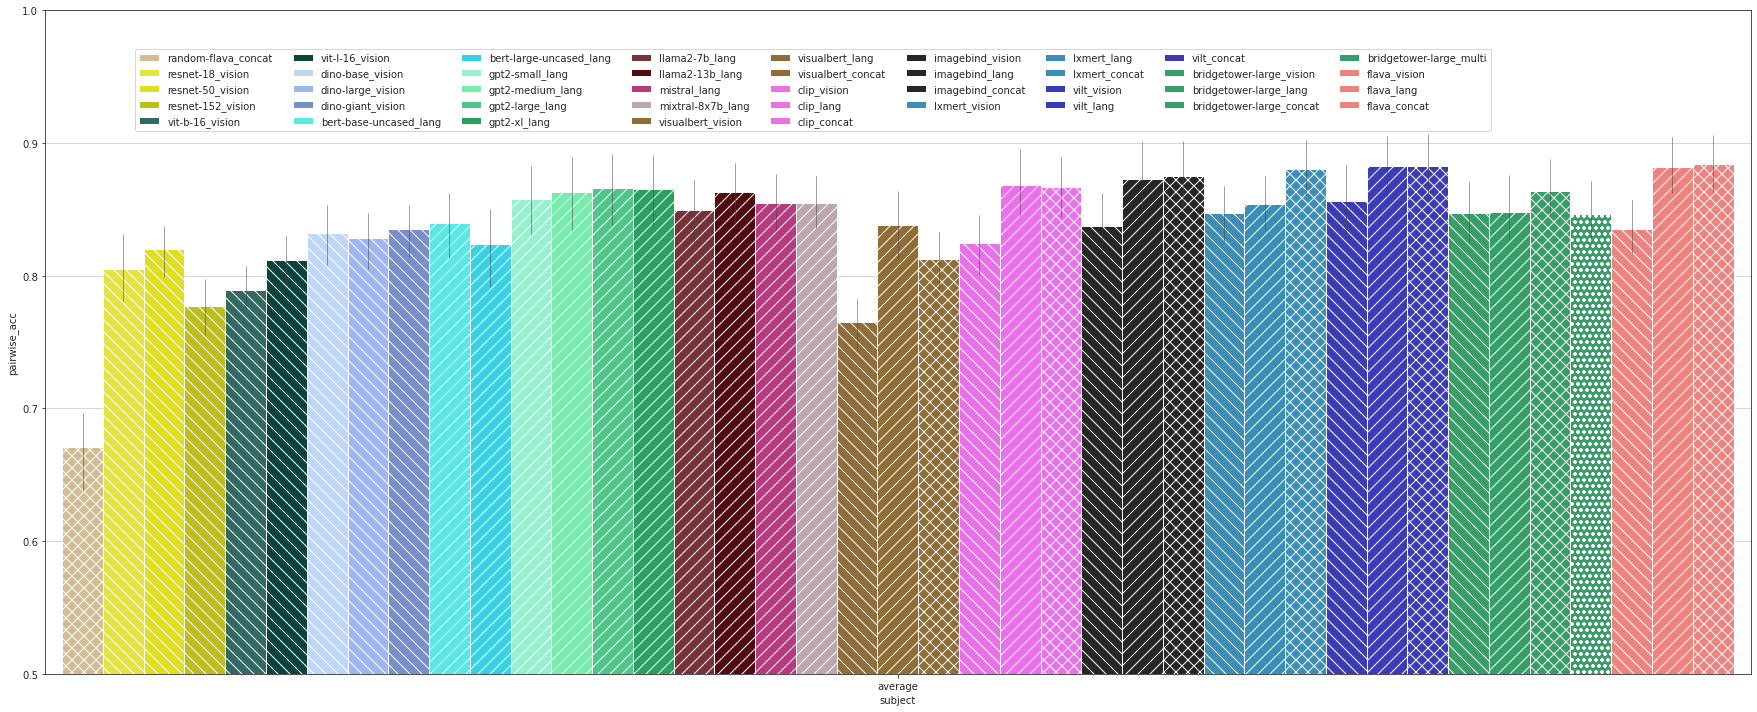

In [11]:
MODELS_EXCLUDED = []
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(MODELS_EXCLUDED)].copy()
data_to_plot = data_to_plot[data_to_plot.training_mode == "train"]

model_feat_order = calc_model_feat_order(data_to_plot)
model_size_palette, hatches = model_size_hatch_palette(data_to_plot, model_feat_order)

assert len(data_to_plot[(data_to_plot.model_feat == "flava_concat") & (data_to_plot.metric == "pairwise_acc")]) == 6

g, data_plotted = plot_metrics_single_subject(data_to_plot, metric="pairwise_acc", x_variable="subject", hue_variable="model_feat", hue_order=model_feat_order, palette=model_size_palette, hatches=hatches)


In [12]:
print(data_to_plot[(data_to_plot.model_feat == "gpt2-large_lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
print(data_to_plot[(data_to_plot.model_feat == "gpt2-xl_lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
print(data_to_plot[(data_to_plot.model_feat == "llama2-13b_lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
print(data_to_plot[(data_to_plot.model_feat == "flava_concat") & (data_to_plot.metric == "pairwise_acc")].value.mean())
print(data_to_plot[(data_to_plot.model_feat == "vilt_concat") & (data_to_plot.metric == "pairwise_acc")].value.mean())


0.8661835748792269
0.8650276052449967
0.8633712905452035
0.8840579710144928
0.8828329882677708


<Figure size 1800x720 with 0 Axes>

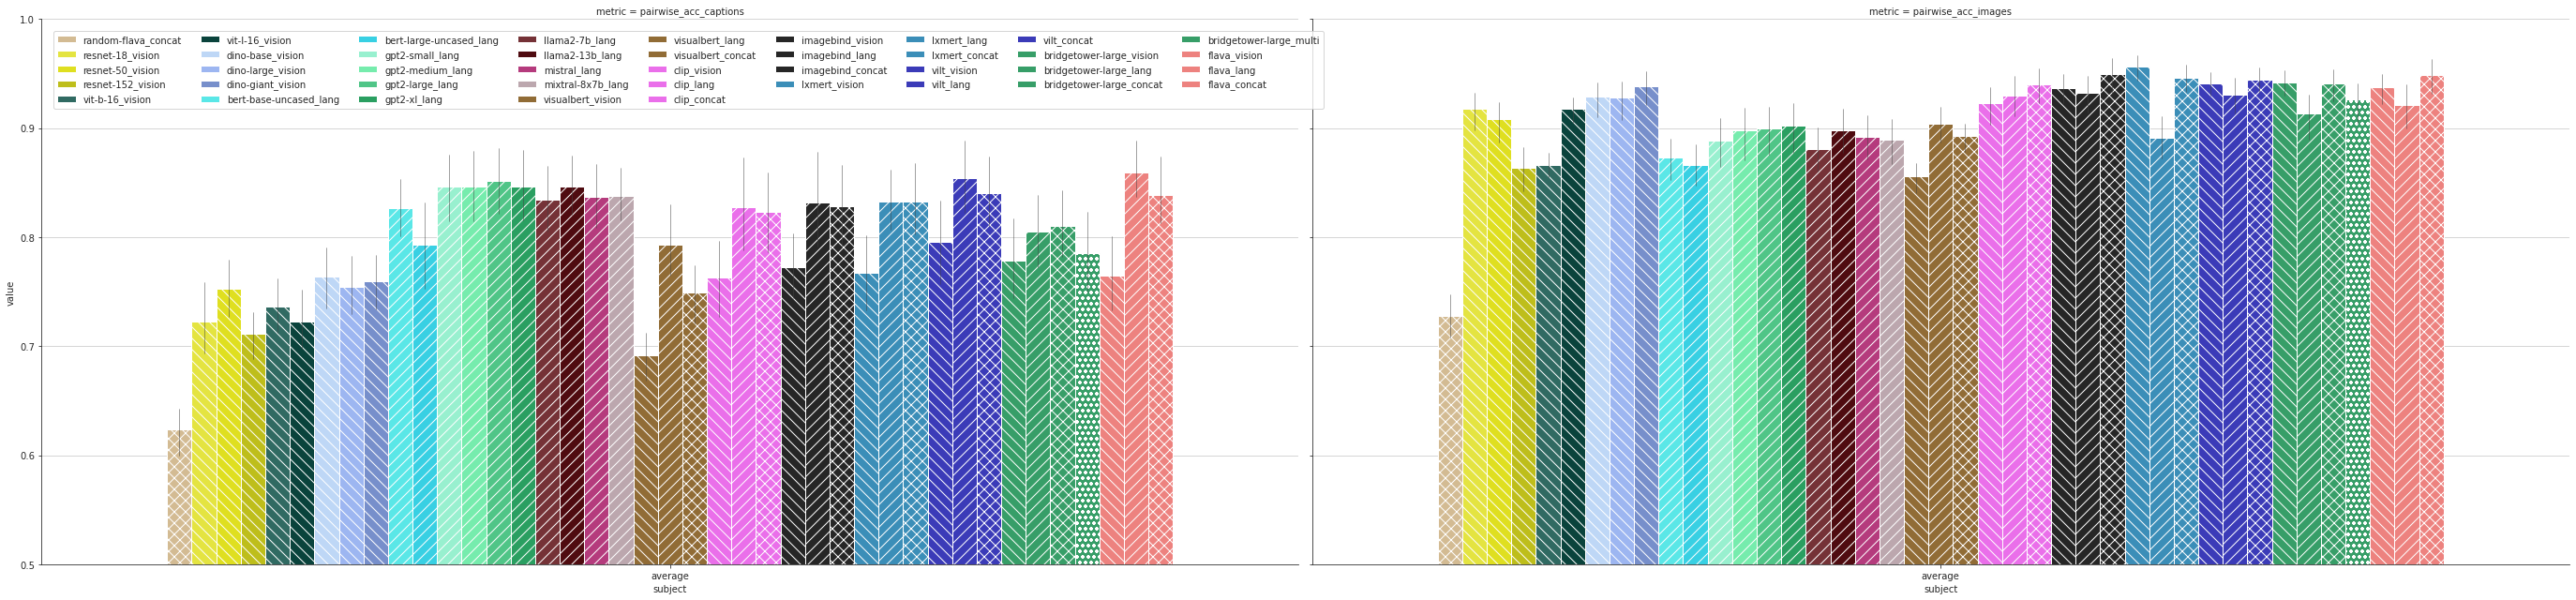

In [13]:
g, _ = plot_metrics(data_to_plot, metrics=["pairwise_acc_captions", "pairwise_acc_images"], x_variable="subject", hue_variable="model_feat", hue_order=model_feat_order, palette=model_size_palette, hatches=hatches)


{'imagebind': '#000000', 'resnet': '#ffff00', 'bert': '#1ce6ff', 'clip': '#ff34ff', 'flava': '#ff4a46', 'bridgetower': '#008941', 'lxmert': '#006fa6', 'mistral': '#a30059', 'visualbert': '#7a4900', 'vilt': '#0000a6', 'gpt2': '#63ffac', 'random': '#b79762', 'vit': '#004d43', 'dino': '#8fb0ff', 'mixtral': '#997d87', 'llama2': '#5a0007'}


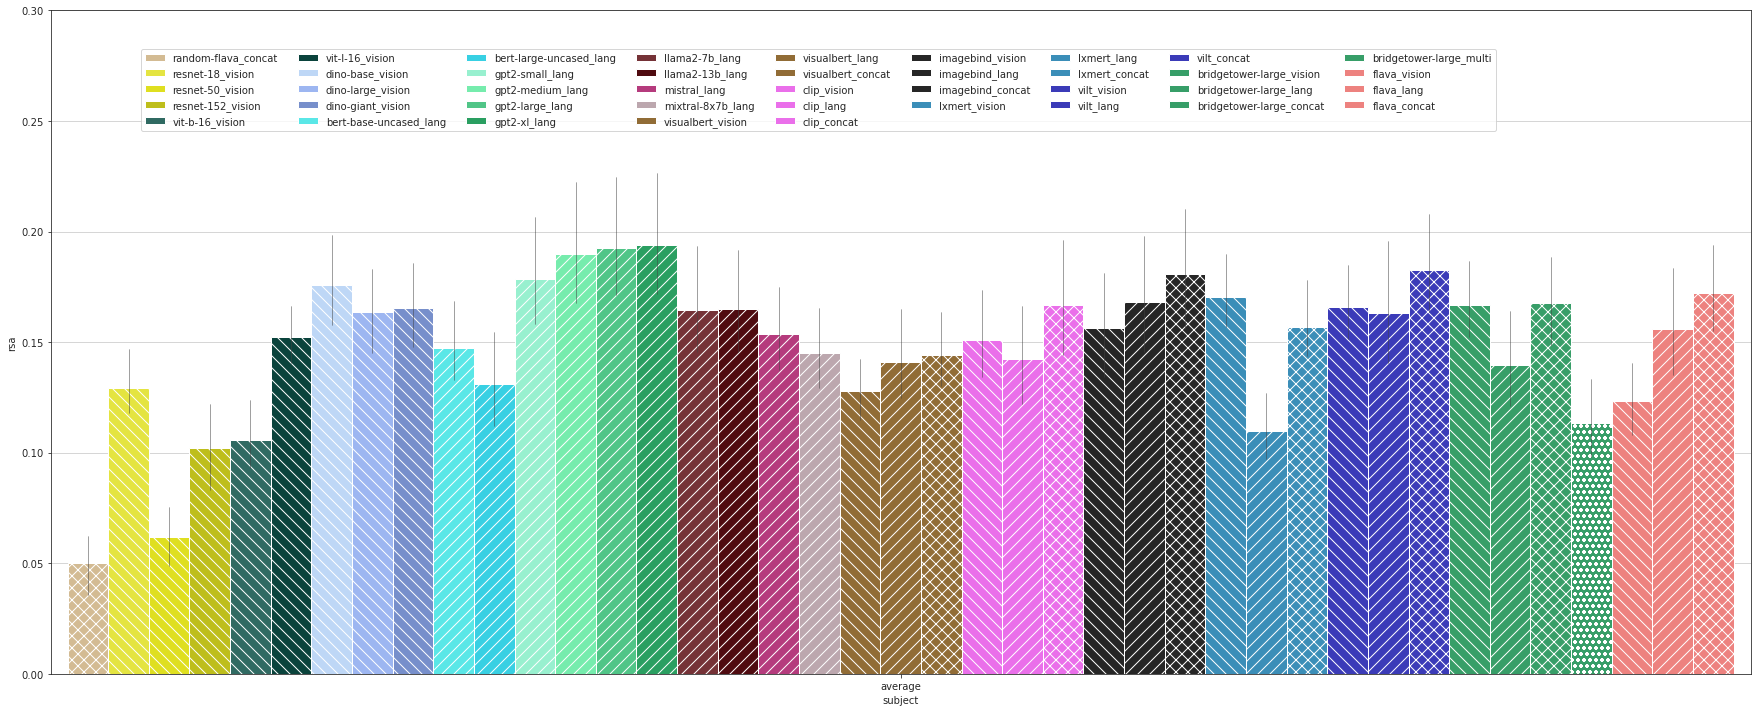

In [14]:
MODELS_EXCLUDED = []
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(MODELS_EXCLUDED)].copy()
data_to_plot = data_to_plot[data_to_plot.training_mode == "train"]

model_feat_order = calc_model_feat_order(data_to_plot)
model_size_palette, hatches = model_size_hatch_palette(data_to_plot, model_feat_order)
g, data_plotted = plot_metrics_single_subject(data_to_plot, metric="rsa", x_variable="subject", hue_variable="model_feat", hue_order=model_feat_order, palette=model_size_palette, hatches=hatches, ylim=(0, 0.3 ))


## Effect of other-modality training data

['dino-giant_vision' 'flava_concat' 'flava_lang' 'flava_vision'
 'gpt2-large_lang' 'gpt2-xl_lang' 'llama2-13b_lang']
{'flava': '#000000', 'llama2': '#ffff00', 'dino': '#1ce6ff', 'gpt2': '#ff34ff'}


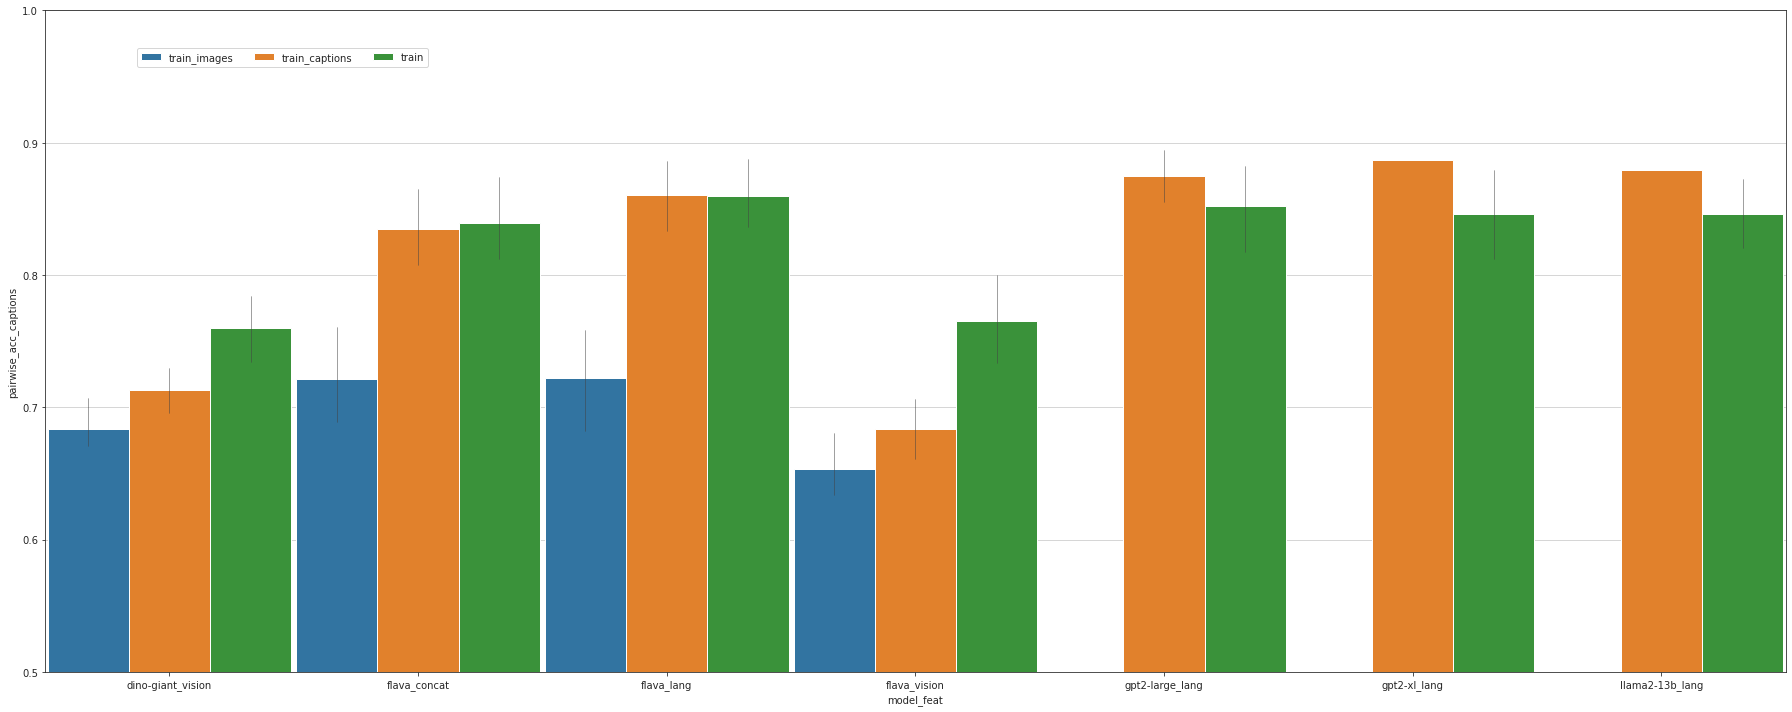

In [24]:
MODE_ORDER = ["train_images", "train_captions", "train"]
MODELS_INCLUDED = all_data_avg[all_data_avg.training_mode.isin(["train_captions"])].model_feat.unique()
data_to_plot = all_data_avg[all_data_avg.model_feat.isin(MODELS_INCLUDED)].copy()
print(MODELS_INCLUDED)

# data_to_plot = data_to_plot[data_to_plot.training_mode.isin(["train", "train_captions"])]

model_feat_order = calc_model_feat_order(data_to_plot)
model_size_palette, hatches = model_size_hatch_palette(data_to_plot, model_feat_order)
g, data_plotted = plot_metrics_single_subject(data_to_plot, metric="pairwise_acc_captions", x_variable="model_feat", hue_variable="training_mode", hue_order=MODE_ORDER)


['dino-giant_vision' 'flava_concat' 'flava_lang' 'flava_vision']
{'flava': '#000000', 'dino': '#ffff00'}


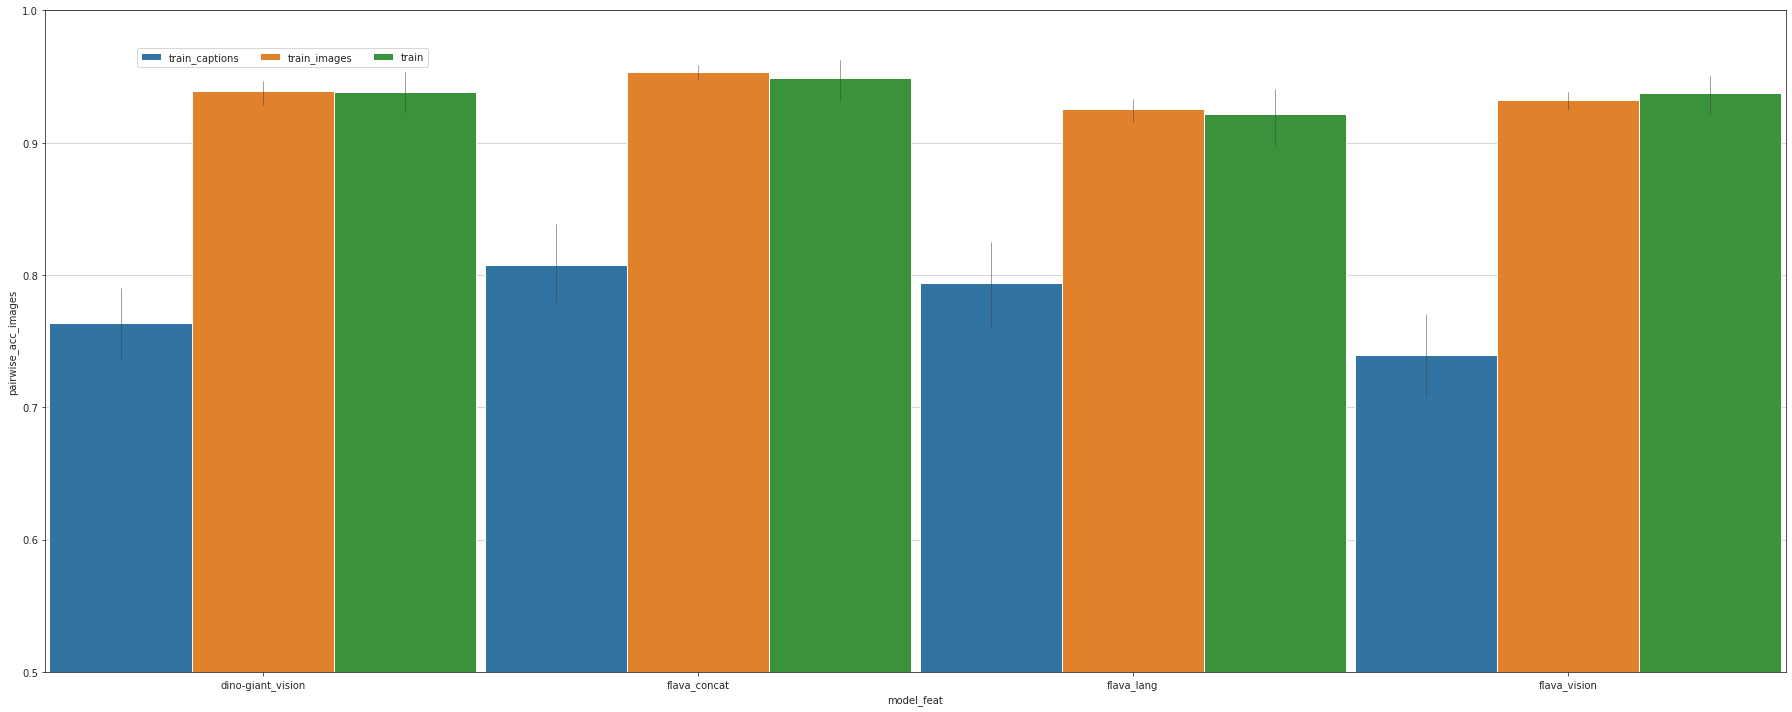

In [23]:
MODE_ORDER = ["train_captions", "train_images", "train"]
MODELS_INCLUDED = all_data_avg[all_data_avg.training_mode.isin(["train_images"])].model_feat.unique()
data_to_plot = all_data_avg[all_data_avg.model_feat.isin(MODELS_INCLUDED)].copy()
print(MODELS_INCLUDED)

# data_to_plot = data_to_plot[data_to_plot.training_mode.isin(["train", "train_images"])]

model_feat_order = calc_model_feat_order(data_to_plot)
model_size_palette, hatches = model_size_hatch_palette(data_to_plot, model_feat_order)
g, data_plotted = plot_metrics_single_subject(data_to_plot, metric="pairwise_acc_images", x_variable="model_feat", hue_variable="training_mode", hue_order=MODE_ORDER)


In [17]:
data_to_plot[(data_to_plot.model_feat == "flava_concat") & (data_to_plot.metric == "pairwise_acc")]


,alpha,model,subject,features,training_mode,testing_mode,best_val_acc,metric,value,fold,best_val_loss,ensemble,model_feat,model_prefix
77,100000.0,flava,average,concat,train,test,True,pairwise_acc,0.887164,NaN,NaN,NaN,flava_concat,flava
317,100000.0,flava,average,concat,train,test,True,pairwise_acc,0.865217,NaN,NaN,NaN,flava_concat,flava
549,100000.0,flava,average,concat,train,test,True,pairwise_acc,0.843685,NaN,NaN,NaN,flava_concat,flava
769,100000.0,flava,average,concat,train,test,True,pairwise_acc,0.895652,NaN,NaN,NaN,flava_concat,flava
989,100000.0,flava,average,concat,train,test,True,pairwise_acc,0.877640,NaN,NaN,NaN,flava_concat,flava
1201,100000.0,flava,average,concat,train,test,True,pairwise_acc,0.934990,NaN,NaN,NaN,flava_concat,flava
1461,100000.0,flava,average,concat,train_images,test,True,pairwise_acc,0.790062,NaN,NaN,NaN,flava_concat,flava
1477,100000.0,flava,average,concat,train_images,test,True,pairwise_acc,0.762319,NaN,NaN,NaN,flava_concat,flava
1493,100000.0,flava,average,concat,train_images,test,True,pairwise_acc,0.821014,NaN,NaN,NaN,flava_concat,flava
1509,100000.0,flava,average,concat,train_images,test,True,pairwise_acc,0.803727,NaN,NaN,NaN,flava_concat,flava


## Per-subject results

In [18]:
# data_to_plot = all_data
# MODELS_EXCLUDED = []
# data_to_plot = all_data[~all_data.model_feat.isin(MODELS_EXCLUDED)]

# data_to_plot = data_to_plot[data_to_plot.best_val_acc == True]

# model_feat_order = calc_model_feat_order(data_to_plot)
# palette = model_feat_color_palette(data_to_plot, model_feat_order)

# g, data_plotted = plot_metrics(data_to_plot, metrics=["pairwise_acc"], palette=palette, hue_order=model_feat_order, add_avg_over_subjects=True)
# g, _ = plot_metrics(data_to_plot, metrics=["pairwise_acc_captions"], palette=palette, hue_order=model_feat_order, add_avg_over_subjects=True)
# g, _ = plot_metrics(data_to_plot, metrics=["pairwise_acc_images"], palette=palette, hue_order=model_feat_order, add_avg_over_subjects=True)


## RSA noise ceiling

In [19]:
rsa_noise_ceilings_path = os.path.join(RSA_NOISE_CEILING_DIR, f"{RSA_METRIC}_{RSA_MATRIX_METRIC}.p")
rsa_noise_ceilings = pickle.load(open(rsa_noise_ceilings_path, 'rb'))
rsa_noise_ceiling_mean = np.mean(list(rsa_noise_ceilings.values()))
rsa_noise_ceiling_std = np.std(list(rsa_noise_ceilings.values()))
print(rsa_noise_ceiling_mean)
print(rsa_noise_ceiling_std)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.7), palette=palette, hue_order=model_feat_order, noise_ceiling=rsa_noise_ceiling_mean)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.3), palette=palette, hue_order=model_feat_order)


0.6013974890618027
0.06041285101993492


In [20]:
all_data[all_data.best_val_acc == True].alpha.unique()

array([1.e+05, 1.e+07, 1.e+03])

In [21]:

# data_to_print = all_data[(all_data.best_val_acc == True) & (all_data.ensemble != True)]
# data_to_print = data_to_print[data_to_print.subject.isin(["sub-01", "sub-02", "sub-03"])]
# # data_to_print = data_to_print[data_to_print.model_feat.str.contains('bert-large-uncased_lang')]
# data_to_print = data_to_print[data_to_print.model_feat.str.contains('vilt_concat')]

# print(len(data_to_print[data_to_print.metric == "pairwise_acc"].value))
# # assert len(data_to_print[data_to_print.metric == "acc_cosine"].value) == 6
# print(data_to_print[data_to_print.metric == "pairwise_acc"].value.mean())
# data_to_print[data_to_print.metric == "pairwise_acc"]

In [22]:

# data_to_print = all_data[(all_data.best_val_mse == True) & (all_data.ensemble != True)]
# data_to_print = data_to_print[data_to_print.subject == "sub-01"]
# data_to_print = data_to_print[data_to_print.model_feat.str.contains('flava_lang')]
# print(len(data_to_print[data_to_print.metric == "pairwise_acc"].value))
# # assert len(data_to_print[data_to_print.metric == "acc_cosine"].value) == 6
# print(data_to_print[data_to_print.metric == "pairwise_acc"].value.mean())
# data_to_print[data_to_print.metric == "pairwise_acc"]